In [1]:
import os
import cv2
import yaml
import time
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [2]:
class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hexs = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
                '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb(f'#{c}') for c in hexs]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
    
class Annotator:
    # YOLOv5 Annotator for train/val mosaics and jpgs and detect/hub inference annotations
    def __init__(self, im, line_width=None,  example='abc'):
        assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to Annotator() input images.'
        # use cv2
        self.im = im
        self.lw = line_width or max(round(sum(im.shape) / 2 * 0.003), 2)  # line width

    def masks(self, masks, colors, im_gpu, alpha=0.5, retina_masks=False):
        """Plot masks at once.
        Args:
            masks (tensor): predicted masks on cuda, shape: [n, h, w]
            colors (List[List[Int]]): colors for predicted masks, [[r, g, b] * n]
            im_gpu (tensor): img is in cuda, shape: [3, h, w], range: [0, 1]
            alpha (float): mask transparency: 0.0 fully transparent, 1.0 opaque
        """


        colors = np.array(colors, dtype=np.float32) / 255.0
        colors = colors[:, None, None]  # shape(n,1,1,3)
        masks = np.expand_dims(masks, axis=3)  # shape(n,h,w,1)
        masks_color = masks * (colors * alpha)  # shape(n,h,w,3)

        inv_alph_masks = (1 - masks * alpha).cumprod(0)  # shape(n,h,w,1)
        mcs = (masks_color * inv_alph_masks).sum(0) * 2  # mask color summand shape(n,h,w,3)

        im_gpu = np.flip(im_gpu, axis=[0])  # flip channel
        im_gpu = np.ascontiguousarray(im_gpu.transpose(1, 2, 0))  # shape(h,w,3)
        im_gpu = im_gpu * inv_alph_masks[-1] + mcs
        im_mask = (im_gpu * 255).astype(np.uint8)
        self.im[:] = scale_image(im_gpu.shape, im_mask, self.im.shape)

    def box_label(self, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
        # Add one xyxy box to image with label
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
        if label:
            tf = max(self.lw - 1, 1)  # font thickness
            w, h = cv2.getTextSize(label, 0, fontScale=self.lw / 3, thickness=tf)[0]  # text width, height
            outside = p1[1] - h >= 3
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(self.im, p1, p2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(self.im,
                        label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                        0,
                        self.lw / 3,
                        txt_color,
                        thickness=tf,
                        lineType=cv2.LINE_AA)

    def result(self):
        # Return annotated image as array
        return self.im

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

def save_one_box(xyxy, im, file='im.jpg', gain=1.02, pad=10, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = np.array(xyxy).reshape(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = np.expand_dims(b[:, 2:].max(1)[0], axis=1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).astype(np.int64)
    clip_boxes(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]
    if save:
        output_file = Path(file)
        output_file.parent.mkdir(parents=True, exist_ok=True)  # make directory
        f = str(output_file)
        # cv2.imwrite(f, crop)  # save BGR, https://github.com/ultralytics/yolov5/issues/7007 chroma subsampling issue
        Image.fromarray(crop[..., ::-1]).save(f, quality=95, subsampling=0)  # save RGB
    return crop

def scale_image(im1_shape, masks, img0_shape, ratio_pad=None):
    """
    img1_shape: model input shape, [h, w]
    img0_shape: origin pic shape, [h, w, 3]
    masks: [h, w, num]
    """
    # Rescale coordinates (xyxy) from im1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(im1_shape[0] / img0_shape[0], im1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (im1_shape[1] - img0_shape[1] * gain) / 2, (im1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        pad = ratio_pad[1]
    top, left = int(pad[1]), int(pad[0])  # y, x
    bottom, right = int(im1_shape[0] - pad[1]), int(im1_shape[1] - pad[0])

    if len(masks.shape) < 2:
        raise ValueError(f'"len of masks shape" should be 2 or 3, but got {len(masks.shape)}')
    masks = masks[top:bottom, left:right]
    # masks = masks.permute(2, 0, 1).contiguous()
    # masks = F.interpolate(masks[None], img0_shape[:2], mode='bilinear', align_corners=False)[0]
    # masks = masks.permute(1, 2, 0).contiguous()
    masks = cv2.resize(masks, (img0_shape[1], img0_shape[0]))

    if len(masks.shape) == 2:
        masks = masks[:, :, None]
    return masks

def clip_boxes(boxes, shape):
    # np.array (faster grouped)
    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def crop_mask(masks, boxes):
    """
    "Crop" predicted masks by zeroing out everything not in the predicted bbox.
    Vectorized by Chong (thanks Chong).

    Args:
        - masks should be a size [h, w, n] tensor of masks
        - boxes should be a size [n, 4] tensor of bbox coords in relative point form
    """

    n, h, w = masks.shape
    x1, y1, x2, y2 = np.array_split(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
    r = np.arange(w, dtype=x1.dtype)[None, None, :]  # rows shape(1,w,1)
    c = np.arange(h, dtype=x1.dtype)[None, :, None]  # cols shape(h,1,1)

    return masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))

def process_mask(protos, masks_in, bboxes, shape, upsample=False):
    """
    Crop before upsample.
    proto_out: [mask_dim, mask_h, mask_w]
    out_masks: [n, mask_dim], n is number of masks after nms
    bboxes: [n, 4], n is number of masks after nms
    shape:input_image_size, (h, w)

    return: h, w, n
    """

    c, mh, mw = protos.shape  # CHW
    ih, iw = shape
    masks = sigmoid(masks_in @ protos.astype(np.float32).reshape(c, -1)).reshape(-1, mh, mw)  # CHW

    downsampled_bboxes = bboxes.copy()
    downsampled_bboxes[:, 0] *= mw / iw
    downsampled_bboxes[:, 2] *= mw / iw
    downsampled_bboxes[:, 3] *= mh / ih
    downsampled_bboxes[:, 1] *= mh / ih

    masks = crop_mask(masks, downsampled_bboxes)  # CHW
    n = masks.shape[0]
    if upsample:
        masks = np.array([cv2.resize(masks[i], shape, interpolation=cv2.INTER_CUBIC) for i in range(n)])

    return masks > 0.5

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        max_det=1000,
        nm=32,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [np.zeros((0, 6 + nm))] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence


        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # best class only
        conf, j = x[:, 5:mi].max(1, keepdims=True), x[:, 5:mi].argmax(1, keepdims=True)
        x = np.concatenate((box, conf, j.astype(np.float32), mask), 1)[conf.flatten() > conf_thres]
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort()[::-1][:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections

        output[xi] = x[i]

    return output

def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

def yaml_load(file='data.yaml'):
    # Single-line safe yaml loading
    with open(file, errors='ignore') as f:
        return yaml.safe_load(f)

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

def align_crop(masks, det, img, names):
    labeled_annots = {}
    for idx, label in enumerate(det[:, 5]):
        label = names[int(label)]
        if label in ['back', 'front']:
             labeled_annots[label] = masks.any(axis=0).astype(np.uint8)*255
        else:
            labeled_annots[label] = det[idx, :4]
    if len(labeled_annots) < 2 or sum(name in labeled_annots for name in ['back', 'front']) != 1:
        return None
    
    mask = labeled_annots['back'] if 'back' in labeled_annots else labeled_annots['front']

    align_pt = None
    is_chip = False
    if all(name in labeled_annots for name in ['front', 'avatar']):
        align_pt = labeled_annots['avatar'].reshape(-1,2).mean(axis=0)
    elif all(name in labeled_annots for name in ['back', 'finger print']):
        align_pt = labeled_annots['finger print'].reshape(-1,2).mean(axis=0)
        if 'chip' in labeled_annots:
            is_chip = True
    else:
        return None

    gain = min(mask.shape[0] / img.shape[0], mask.shape[1] / img.shape[1])  # gain  = old / new
    pad = (mask.shape[1] - img.shape[1] * gain) / 2, (mask.shape[0] - img.shape[0] * gain) / 2  # wh padding

    top, left = int(pad[1]), int(pad[0])  # y, x
    bottom, right = int(mask.shape[0] - pad[1]), int(mask.shape[1] - pad[0])

    mask = mask[top:bottom, left:right]
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
  
    # convert mask to grayscale
    
    contours, hierachy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_thresh = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > area_thresh:
            area_thresh = area
            big_contour = c

    # get rotated rectangle from contour
    epsilon = 0.05*cv2.arcLength(big_contour,True)
    approx = cv2.approxPolyDP(big_contour,epsilon,True)
    if len(approx) != 4:
        return None

    pts1 = np.float32(approx).squeeze()
    distance_from_pt1 = ((pts1-pts1[1])**2).sum(axis=-1)
    pts1 = pts1 if distance_from_pt1[0] <= distance_from_pt1[2] else np.roll(pts1, -1, axis=0)

    # counter-clockwise
    pts2 = np.float32([[0, 0], [0, 640], [900, 640], [900, 0]])
    mat = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, mat, (900, 640))

    transformed_align_pt = (mat@np.append(align_pt,1))[:-1]

    farthest_to_alignpt_idx = ((pts2-transformed_align_pt)**2).sum(axis=-1).argmax()
    if not is_chip and farthest_to_alignpt_idx < 2:
        result = cv2.rotate(result, cv2.ROTATE_180)
    elif is_chip and farthest_to_alignpt_idx >=2 :
        result = cv2.rotate(result, cv2.ROTATE_180)

    return result
        
class IdDetector():
    def __init__(self, model_path="./train/checkpoints/best-fp16.tflite", imgsz=(640, 640), stride=32, conf_thres=0.5, iou_thres=0.5, data="./train/data/dataset/data.yaml"):
        # Load the TFLite model and allocate tensors.
        self.interpreter = tf.lite.Interpreter(model_path)
        self.interpreter.allocate_tensors()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.imgsz = imgsz
        self.stride = stride
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.names = yaml_load(data)['names']

        self.colors = Colors()

    def __call__(self, img):
        '''
        img: B C H W, RGB
        '''
        b, ch, h, w = img.shape
        img = img.transpose(0, 2, 3, 1)

        input = self.input_details[0]
        int8 = input['dtype'] == np.uint8  # is TFLite quantized uint8 model
        if int8:
            scale, zero_point = input['quantization']
            img = (img / scale + zero_point).astype(np.uint8)  # de-scale
        self.interpreter.set_tensor(input['index'], img)
        self.interpreter.invoke()
        y = []
        for output in self.output_details:
            x = self.interpreter.get_tensor(output['index'])
            if int8:
                scale, zero_point = output['quantization']
                x = (x.astype(np.float32) - zero_point) * scale  # re-scale
            y.append(x)
        y = [x if isinstance(x, np.ndarray) else x.numpy() for x in y]
        y[0][..., :4] *= [w, h, w, h]  # xywh normalized to pixels
        return y

    def predict_image(self, img_path):
       
        img0 = cv2.imread(img_path)
        img = letterbox(img0, self.imgsz, stride=self.stride, auto=False)[0]  # padded resize
        img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)

        img = img.astype(np.float32)
        img /= 255  # 0 - 255 to 0.0 - 1.0
        if len(img.shape) == 3:
            img = img[None]  # expand for batch dim

        # Inference + NMS
        pred, proto = self(img)
        
        det = non_max_suppression(pred, self.conf_thres, self.iou_thres)[0]
        # Process predictions -- pred[0].shape: (1, 38), ptoro.shape: 1 32 160 160
        if not det.shape[0]:
            return None

        masks = process_mask(proto[0], det[:, 6:], det[:, :4], img.shape[2:], upsample=True)  # HWC model image size
        det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round() # original image size, img0.shape

        result = align_crop(masks, det, img0, self.names)
        if result is None:
            return None
        else:
            return result

In [3]:
imgsz = (640, 640)
stride = 32
conf_thres = 0.8
iou_thres = 0.8
data = "train/data/dataset/data.yaml"
model_path="train/checkpoints/best-fp16.tflite"
# model_path="yolov5/runs/train-seg-old/exp6/weights/best-fp16.tflite"

detector = IdDetector(model_path=model_path,
                        imgsz=imgsz, stride = stride, conf_thres=conf_thres, iou_thres=iou_thres, data=data)

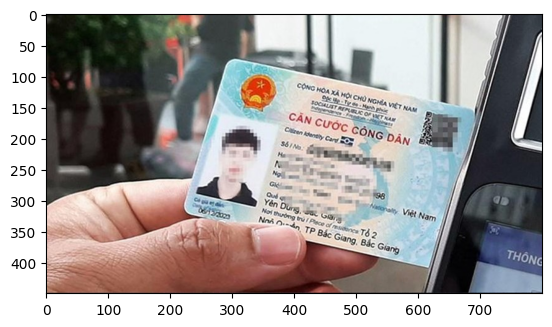

In [4]:

test_image_path = "yolov5/data/id-cards/train/images/001075006200-1.jpg"
test_image_path = "yolov5/data/id-cards/train/images/001087015887-1.jpg"
test_image_path = "yolov5/data/id-cards/train/images/9.jpg"
test_image_path = "/Users/hieuphandinhminh/Downloads/le-phi-cap-the-can-cuoc-cong-dan-gan-chip-1616738008513495018289-crop-1616738067223735022716.jpeg"
# test_image_path = "/Users/hieuphandinhminh/Pictures/Picture1.png"

origin_image = cv2.imread(test_image_path)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(origin_image)


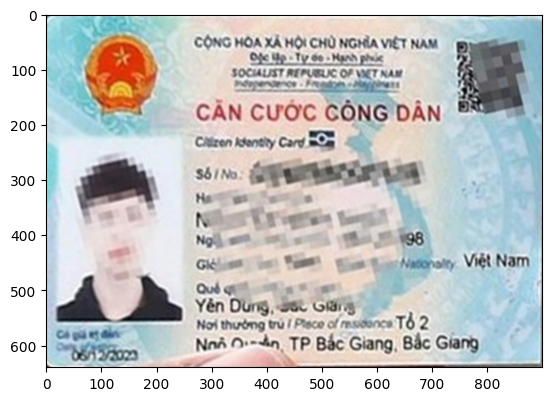

In [5]:
crop_and_align_image = detector.predict_image(test_image_path)
crop_and_align_image = cv2.cvtColor(crop_and_align_image, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(crop_and_align_image)